In [ ]:
# The MLP teacher model to predict the california housing dataset 

In [1]:
# Split the training data into validation set and training set use a stratified k fold 
import numpy as np
from sklearn.model_selection import KFold
import pandas as pd
import sklearn

from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import RobustScaler, QuantileTransformer 

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
import Regression_Tree_Forest

from Regression_Tree_Forest.random_forest import *

pygame 2.5.1 (SDL 2.28.2, Python 3.9.17)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
# Load the saved dataset
wind_data_train = pd.read_csv('Data/wind_train_data.txt')
wind_data_test = pd.read_csv('Data/wind_test_data.txt')

In [5]:
# This dataset have strong outliers due to the hard limit of the housing price
# remove those from the training set

print(wind_data_train.shape)

print(wind_data_test.shape)

(33864, 31)
(14514, 31)


In [6]:
# Perform the stratified 10 fold cross validation
number_of_folds = 10

kfolds = KFold(n_splits=number_of_folds)

col_to_use = [
    'A_Air_temp', 'A_Precip', 'A_Syno_wind_speed',
       'A_Syno_wind_dir', 'A_Avg_wind_speed', 'A_Avg_wind_dir', 'B_Air_temp',
       'B_Precip', 'C_Air_temp', 'C_Precip', 'C_Syno_wind_speed',
       'C_Syno_wind_dir', 'D_Air_temp', 'D_Precip', 'D_Syno_wind_speed',
       'D_Syno_wind_dir', 'D_Avg_wind_speed', 'D_Avg_wind_dir', 'E_Air_temp',
       'E_Precip', 'E_Syno_wind_speed', 'E_Syno_wind_dir', 'E_Avg_wind_speed',
       'E_Avg_wind_dir'
]

x_train = wind_data_train.loc[:, col_to_use].to_numpy()

y_train = wind_data_train.loc[:, [
    'Test_Avg_wind_speed',
      # 'Test_Avg_wind_dir'
]].to_numpy()

x_test = wind_data_test.loc[:, [
    'A_Air_temp', 'A_Precip', 'A_Syno_wind_speed',
       'A_Syno_wind_dir', 'A_Avg_wind_speed', 'A_Avg_wind_dir', 'B_Air_temp',
       'B_Precip', 'C_Air_temp', 'C_Precip', 'C_Syno_wind_speed',
       'C_Syno_wind_dir', 'D_Air_temp', 'D_Precip', 'D_Syno_wind_speed',
       'D_Syno_wind_dir', 'D_Avg_wind_speed', 'D_Avg_wind_dir', 'E_Air_temp',
       'E_Precip', 'E_Syno_wind_speed', 'E_Syno_wind_dir', 'E_Avg_wind_speed',
       'E_Avg_wind_dir'
]].to_numpy()

y_test = wind_data_test.loc[:, [
    'Test_Avg_wind_speed',
      # 'Test_Avg_wind_dir'
]].to_numpy()

In [27]:
# Haperparameter used in the experiment
number_of_trees = 100
max_depth = 10
min_samples_split = 2

train_val_results = []

for i, (train_index, val_index) in enumerate(kfolds.split(x_train, y_train)):
    print(f"Fold {i}")

    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    
    x_val_fold = x_train[val_index]
    y_val_fold = y_train[val_index]
    
    forest = make_forest(
        x_train_fold, 
        y_train_fold, 
        number_of_trees,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        labels=col_to_use
    )
        
    val_prediction = forest.predict_all(x_val_fold)
    val_mse = mean_squared_error(y_val_fold, val_prediction)
    
    # Record the result for each of 10 folds
    train_val_results.append({
        'mse' : np.mean(forest.get_loss()),
        'val_mse' : val_mse
    })
    
print('Traning done')

Fold 0
Forest generated
Fold 1
Forest generated
Fold 2
Forest generated
Fold 3
Forest generated
Fold 4
Forest generated
Fold 5
Forest generated
Fold 6
Forest generated
Fold 7
Forest generated
Fold 8
Forest generated
Fold 9
Forest generated
Traning done


In [24]:
# Retrain the model to evaluate the performance
forest = make_forest(
    x_train, 
    y_train, 
    number_of_trees,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    labels=col_to_use
)

test_pred = forest.predict_all(x_test)
test_results = mean_squared_error(y_test, test_pred)

Forest generated


Average MSE for training data for last epoch 1.3529046696468239+-0.04036196716203685
Average MSE for validation data for last epoch 4.6038488458769695+-0.14820343400004948
MSE for testing data 4.576561977990502


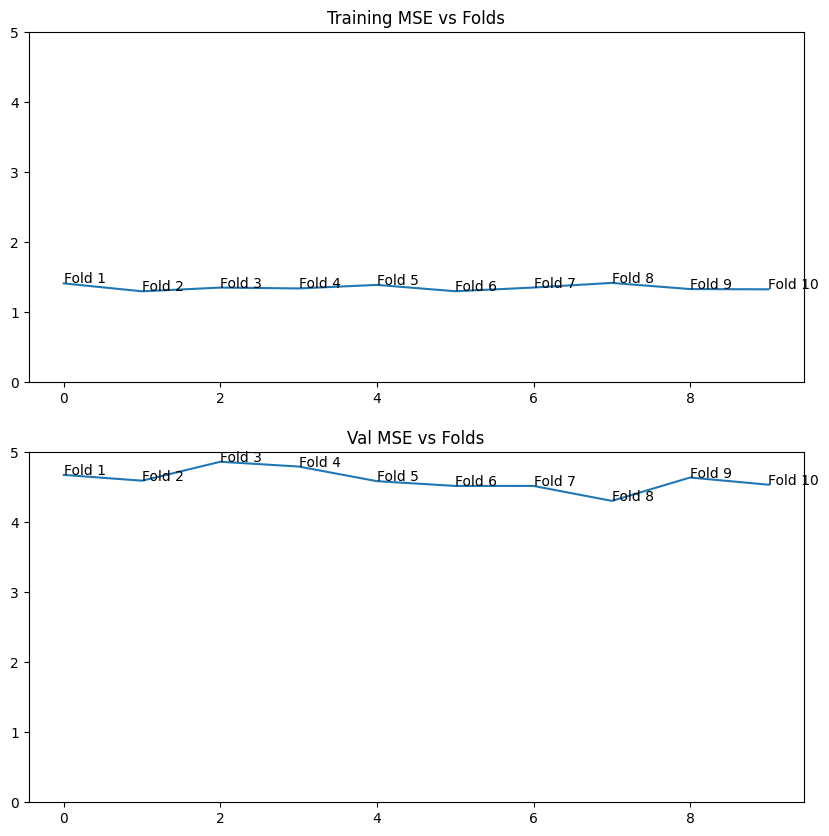

In [31]:
# Modified from source: https://stackoverflow.com/questions/12957582/plot-yerr-xerr-as-shaded-region-rather-than-error-bars
fig, axs = plt.subplots(2, 1, figsize = (10, 10))
x = range(0, number_of_folds)

# Training loss
i = 1

axs[0].plot(x, [d['mse'] for d in train_val_results], '-') 
for fold in [d['mse'] for d in train_val_results]:
    axs[0].annotate(f"Fold {i}", (i-1,fold))
    i = i+1
    
    
axs[0].title.set_text('Training MSE vs Folds') 
axs[0].set_ylim(0, 5)

# Validation loss
i = 1
axs[1].plot(x, [d['val_mse'] for d in train_val_results], '-') 
for fold in [d['val_mse'] for d in train_val_results]:
    axs[1].annotate(f"Fold {i}", (i-1,fold))
    i = i+1
    
axs[1].title.set_text('Val MSE vs Folds') 
axs[1].set_ylim(0, 5)

# Report the training std of the mse
# Get the MSE for the training and valiation dataset
train_mses = [d['mse'] for d in train_val_results]
val_mses = [d['val_mse'] for d in train_val_results]

train_mse_stds = np.std(train_mses)
val_mse_stds = np.std(val_mses)

# Report MSE
print(f"Average MSE for training data for last epoch {np.mean(train_mses)}"f"+-{np.mean(train_mse_stds)}")
print(f"Average MSE for validation data for last epoch {np.mean(val_mses)}"f"+-{np.mean(val_mse_stds)}")

print(f"MSE for testing data {test_results}")

Text(0, 0.5, 'Predicted values')

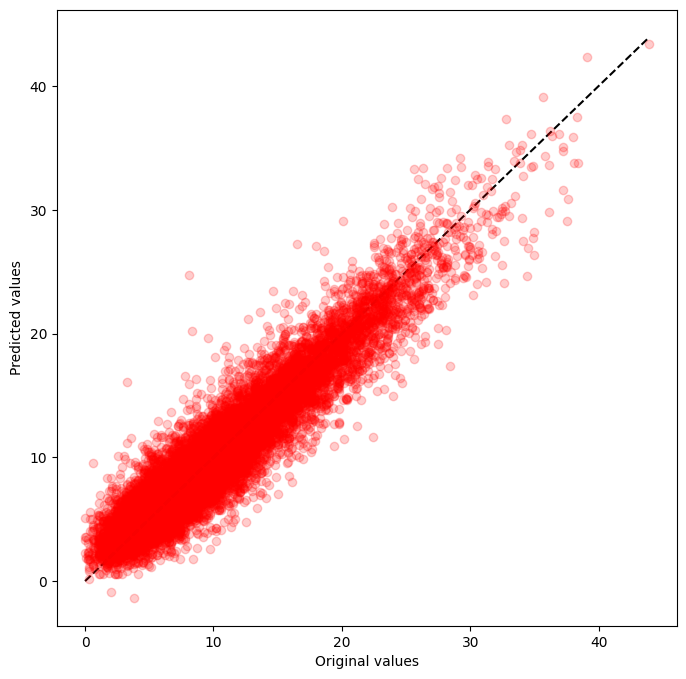

In [41]:

# Also plot the actual vs predicted value
plt.figure(figsize=(8,8))

ax = plt.gca()
# ax.set_xlim([0, 5])
# ax.set_ylim([0, 5])

plt.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)], 'k--')
plt.plot(y_test, prediction, 'ro', alpha=.2)
plt.xlabel('Original values')
plt.ylabel('Predicted values')

In [42]:
teacher_model.save('WindTeacherModel/MlpTeacherModel')

INFO:tensorflow:Assets written to: WindTeacherModel/MlpTeacherModel\assets
